# Titanic classifier

In [0]:
import pandas as pd
import numpy as np
np.random.seed(8)

👇 Import the titanic dataset below

In [0]:
import seaborn as sns
data = sns.load_dataset('titanic').drop(columns=['alive'])
data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,True


🔥 Your goal is to use SVM classifiers to test if a passenger survived or not (accuracy score), and compare your performance to your buddy of the day on an unseen test set that you will both share. Be aware that you will only have one trial on the test set!

❓ Write down below in pseudo code the different steps your are going to perform to answer the question.

In [0]:
# Your answer here

<details><summary>Read our answer suggested answer below</summary>
    
    
1. feature encoding
2. train/test split
3. data cleaning
3. feature scaling
4. model tuning: cross-validated randomsearch (coarse grain first, fine grain after)
5. True performance analysis on test set
</details>

## Encoding

❓ Encode your categorical variables

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data.survived)
data.survived = encoder.transform(data.survived)
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


In [0]:
categorical_features = ['sex', 'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alone']
dummies = pd.get_dummies(data[categorical_features])
data = pd.concat([data, dummies], axis=1).drop(columns=categorical_features)
data

,survived,pclass,age,sibsp,parch,fare,deck,sex_female,sex_male,embarked_C,...,embarked_S,class_First,class_Second,class_Third,who_child,who_man,who_woman,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton
0,0,3,22.0,1,0,7.2500,NaN,0,1,0,...,1,0,0,1,0,1,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,1,0,1,...,0,1,0,0,0,0,1,1,0,0
2,1,3,26.0,0,0,7.9250,NaN,1,0,0,...,1,0,0,1,0,0,1,0,0,1
3,1,1,35.0,1,0,53.1000,C,1,0,0,...,1,1,0,0,0,0,1,0,0,1
4,0,3,35.0,0,0,8.0500,NaN,0,1,0,...,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,NaN,0,1,0,...,1,0,1,0,0,1,0,0,0,1
887,1,1,19.0,0,0,30.0000,B,1,0,0,...,1,1,0,0,0,0,1,0,0,1
888,0,3,NaN,1,2,23.4500,NaN,1,0,0,...,1,0,0,1,0,0,1,0,0,1
889,1,1,26.0,0,0,30.0000,C,0,1,1,...,0,1,0,0,0,1,0,1,0,0


❓ Deal with missing values on your train set as you see fit (do not create data-leaks)

In [0]:
data.drop(columns='deck', inplace=True)
data.dropna(inplace=True)

❓ Create X and y

In [0]:
X = data.drop(columns="survived")
y = data["survived"]
print(X.shape)
print(y.shape)

(714, 19)
(714,)


## Holdout

❓ Holdout 30% of your dataset as test set for final evaluation  
(⚠️ use `random_state=0` to compare final results with your buddy)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

## Data cleaning

❓ Scale your training set using the scaler of your choice

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

## Baseline Model

❓ Cross-validate a baseline linear SVC model using the accuracy score. 

In [0]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
model = SVC(kernel='linear')
cross_val_score(model, X_train_scaled, y_train, cv=5).mean()

CPU times: user 51.7 ms, sys: 6 ms, total: 57.7 ms
Wall time: 57.4 ms


0.8197171717171716

## Random Search

👇 Use a **Random search** to optimize both the parameters `kernel` and `C` of an SVM classifier (SVC), and any other hyperparams of your choice. 
- Start with a total of n_iter=100 combinations, cross-validated 5-time each.
- Use verbose=1 or 2 to check progress
- use n_jobs=-1 to use all your CPU cores

⚠️ If the RandomizedSearchCV seems stuck after more than 10 seconds, make one search per SVM kernel. sklearn sometime experiences issues with grid_searching multiple kernel at a time

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

# Instanciate model
model = SVC()

# Hyperparameter search space
search_space = {
    'kernel': ['rbf'],
    'C': stats.uniform(0.01, 100),
    'gamma': stats.loguniform(0.001, 100)
    #'degree': stats.randint(1, 5),
}

# Instanciate Random Search
rsearch = RandomizedSearchCV(
    model, search_space,
    n_jobs=-1, scoring='accuracy', cv=5, n_iter=1000, verbose=1)

In [0]:
%%time
rsearch.fit(np.array(X_train_scaled), np.array(y_train))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.6s


CPU times: user 2.04 s, sys: 63.2 ms, total: 2.11 s
Wall time: 8.55 s


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    8.4s finished


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=1000, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1232ec3a0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1232ec970>,
                                        'kernel': ['rbf']},
                   scoring='accuracy', verbose=1)

❓ What are the best parameters and what is the best score?

In [0]:
rsearch.best_params_

{'C': 98.0709447455047, 'gamma': 0.005896833165286777, 'kernel': 'rbf'}

In [0]:
rsearch.best_score_

0.8317171717171717

In [0]:
model = rsearch.best_estimator_
model.fit(X_train_scaled, y_train)
print(cross_val_score(model, X_train_scaled, y_train, cv=5).mean())

0.8317171717171717


## Final test score

Select the best model you want to put to test. You will compare your result with your buddy of the day!

Compute its `accuracy`, `classification_report` and the `confusion_matrix` on the test set.

⚠️ You can only test one model. Once you have seen the test set, any other optimization would result in data-leakage 

In [0]:
best_model = SVC(C=98.0709447455047, gamma=0.005896833165286777)
best_model.fit(scaler.transform(X_train), y_train)

SVC(C=98.0709447455047, gamma=0.005896833165286777)

In [0]:
from sklearn.metrics import classification_report

# Use model to predict
y_pred = best_model.predict(scaler.transform(X_test))

# Compare predictions and true values to produce classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       125
           1       0.81      0.72      0.76        90

    accuracy                           0.81       215
   macro avg       0.81      0.80      0.81       215
weighted avg       0.81      0.81      0.81       215



## Confusion matrix

Plot the [confusion matric](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

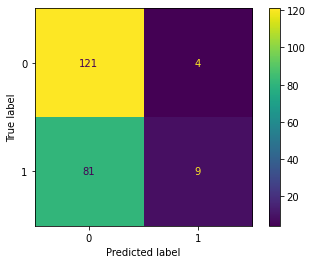

In [0]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test)